In [24]:
import numpy as np
from matplotlib import pyplot as plt
from scipy import stats

# Toy problem: linear fit

Assume we have a set of points $(x, y)$ with Gaussian errors on $y$. We fit them with a linear function
and investigate how do the results vary with respect to priors put on the parameters.


In [68]:
k_true = 100
b_true = 8


def linear(x, k, b):
    return k * x + b

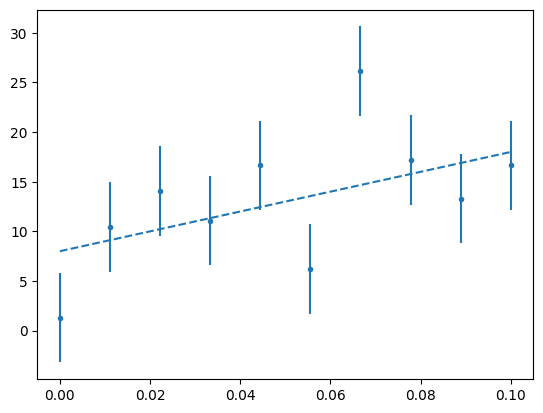

In [70]:
x_data = np.linspace(0, 1e-1, 10)
sigma = linear(x_data[len(x_data) // 2], k_true, b_true) / 3
y_data = linear(x_data, k_true, b_true) + stats.norm.rvs(scale=sigma, size=x_data.size)
y_data_err = sigma * np.ones_like(y_data)

fig, ax = plt.subplots()
ax.errorbar(x_data, y_data, y_data_err, fmt=".")
x_grid = np.linspace(x_data[0], x_data[-1], 100)
ax.plot(x_grid, linear(x_grid, k_true, b_true), color="tab:blue", linestyle="--")
plt.show()

# Bayesian inference and posterior marginal


In [73]:
from typing import Literal

import emcee

PriorKind = Literal["flat", "linear"]


def logprior(v: float, kind: PriorKind) -> float:
    match kind:
        case "flat":
            return 0
        case "linear":
            if v < 0:
                return -np.inf
            return np.log(v)
        case _:
            raise RuntimeError(f"Unexpected prior kind: {kind}")


def compute_sample(k_prior: PriorKind, b_prior: PriorKind) -> np.ndarray:
    def logpost(theta: np.ndarray) -> float:
        k, b = theta
        prediction = linear(x_data, k, b)
        loglike = -0.5 * (((prediction - y_data) / y_data_err) ** 2).sum()
        return logprior(k, k_prior) + logprior(b, b_prior) + loglike

    n_walkers = 128
    sampler = emcee.EnsembleSampler(
        nwalkers=n_walkers,
        ndim=2,
        log_prob_fn=logpost,
    )

    _ = sampler.run_mcmc(
        initial_state=0.1 * stats.norm.rvs(size=(n_walkers, 2)) + np.array([k_true, b_true]),
        nsteps=10_000,
        progress=True,
    )

    print(f"acceptance fraction = {sampler.acceptance_fraction.mean()}")
    tau = sampler.get_autocorr_time().mean()
    print(f"autorocc time = {tau}")

    burn_in = 10 * int(tau)
    thin = 3 * int(tau)
    sample: np.ndarray = sampler.get_chain(flat=True, thin=thin, discard=burn_in)  # type: ignore
    print(f"sample shape = {sample.shape}")

    return sample

100%|██████████| 10000/10000 [00:09<00:00, 1109.17it/s]


acceptance fraction = 0.7154812500000001
autorocc time = 30.64709681964738
sample shape = (13696, 2)


100%|██████████| 10000/10000 [00:09<00:00, 1037.81it/s]


acceptance fraction = 0.71488671875
autorocc time = 32.12019948346163
sample shape = (12800, 2)



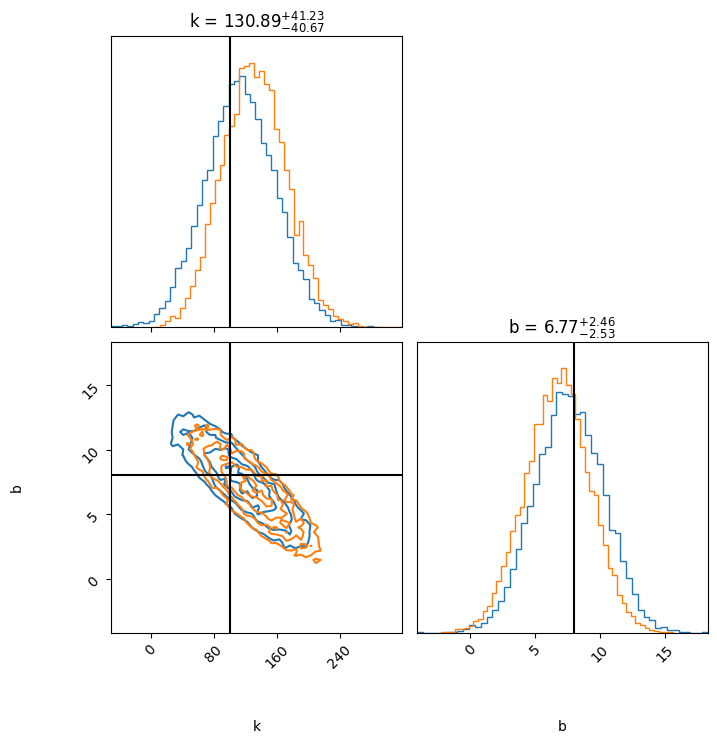

In [75]:
from typing import Any

import corner

fig = plt.figure(figsize=(8, 8))


def kwargs(color: str) -> dict[str, Any]:
    return dict(
        fig=fig,
        bins=50,
        labels=["k", "b"],
        show_titles=True,
        no_fill_contours=True,
        plot_datapoints=False,
        plot_density=False,
        color=color,
        hist_kwargs=dict(
            density=True,
        ),
    )


corner.corner(compute_sample("flat", "flat"), **kwargs("tab:blue"))
corner.corner(compute_sample("linear", "flat"), **kwargs("tab:orange"))
corner.overplot_lines(fig, [k_true, b_true], color="k")
print()